In [ ]:
# Run if you want to get rid of water, leave only protein and make the molecules whole
! echo 1 | gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/output_no_water.xtc -pbc mol # make the molecules whole again!
! echo 1 | gmx trjconv -f ../dynamic.gro -s ../dynamic.tpr -o vars/output_no_water.gro -pbc mol

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF_s
import warnings
from MDAnalysis.analysis import contacts
from matplotlib import pyplot as plt
#https://docs.mdanalysis.org/2.7.0/documentation_pages/analysis/rdf.html
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')
from MDAnalysis.lib import distances
from matplotlib import pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np

gro_file = "vars/output_no_water.gro"
xtc_file = "vars/output_no_water-short.xtc"
# maybe use unwrapped????

u= mda.Universe(gro_file, xtc_file)
print(u)
print("Using MDAnalysis version", mda.__version__)

NUM_RES = 59
NUM_PROTEINS = 50
PROTEIN_LEN = 129
RNA_LEN = 159 # indicates the rna length
NUM_RNA = 50
NUM_RES_RNA = 24 #how many RESIDUES (nucleotide bases) in one rna
RNA_START_INDEX = NUM_PROTEINS * PROTEIN_LEN

all_prot = u.select_atoms(f"bynum 1:6450")
prot1 = u.select_atoms(f"bynum 1:{PROTEIN_LEN}")
prot2 = u.select_atoms(f"bynum {PROTEIN_LEN+1}:{2*PROTEIN_LEN}")
print(len(prot1))
prot2_50 = u.select_atoms(f"bynum {PROTEIN_LEN+1}:6450")
print(len(prot2_50))
args = [[all_prot, all_prot]]


/opt/conda/envs/gromacs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Universe with 14400 atoms>
Using MDAnalysis version 2.8.0
129
6321


In [2]:
def plot_dist(res_dist, cutoff, mode, vmax = 0):
    fig2, ax2 = plt.subplots()
    if vmax == 0:
        im2 = ax2.imshow(res_dist, aspect='auto', origin='lower')
    else:
        im2 = ax2.imshow(res_dist, aspect='auto', origin='lower', vmax=vmax)

    # add residue ID labels to axes
    tick_interval = 10
    ax2.set_yticks(np.arange(res_dist.shape[0])[::tick_interval])
    ax2.set_xticks(np.arange(res_dist.shape[1])[::tick_interval])
    # ax2.set_yticklabels(prot1.residues.resids[::tick_interval])
    # ax2.set_xticklabels(prot1.residues.resids[::tick_interval])

    # add figure labels and titles
    plt.ylabel('residue #')
    plt.xlabel('residue #')
    plt.title(f"Distance between center-of-mass of the residues {mode}, cutoff {cutoff}")

    # # colorbar
    cbar2 = fig2.colorbar(im2)
    cbar2.ax.set_ylabel('Contacts')
    plt.show()


In [3]:

# Define the function to process contacts within a single job
def contacts_within_cutoff_job(gro_file, xtc_file, start_index, end_index, max_atoms, radius=20):
    u = mda.Universe(gro_file, xtc_file)  # Initialize a new Universe for each job
    prot_i = u.select_atoms(f"bynum {start_index}:{end_index}")
    prot_others = u.select_atoms(f"bynum 1:{max_atoms} and not bynum {start_index}:{end_index}")
    
    size1 = len(prot_i.center_of_mass(compound='residues'))
    size2 = len(prot_others.center_of_mass(compound='residues'))
    tot_contacts = np.zeros((size1, size2))

    for ts in u.trajectory:
        res_com1 = prot_i.center_of_mass(compound='residues')
        res_com2 = prot_others.center_of_mass(compound='residues')
        com_dist = distances.distance_array(res_com1, res_com2, box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        tot_contacts += contact_mat  # In-place addition to avoid memory overhead

    return tot_contacts

def contacts_rna_rna_job(gro_file, xtc_file, start_index, end_index, max_atoms, radius=20):
    u = mda.Universe(gro_file, xtc_file)
    #this might not be the best choice because I would have to worry about indexing once here and once in a different funciton
    # maybe correct this later
    rna_i = u.select_atoms(f"bynum {start_index}:{end_index}")
    rna_others = u.select_atoms(f"bynum {RNA_START_INDEX+1}:{max_atoms} and not bynum {start_index}:{end_index}")
    # print(f"bynum {start_index}:{end_index}")
    # print(-start_index+end_index)
    # print(rna_others.n_atoms)
    size1 = len(rna_i.center_of_mass(compound="residues"))
    size2 = len(rna_others.center_of_mass(compound=("residues")))
    tot_contacts = np.zeros((size1, size2))
    
    for ts in u.trajectory:
        res_com1 = rna_i.center_of_mass(compound="residues")
        res_com2 = rna_others.center_of_mass(compound="residues")
        com_dist = distances.distance_array(res_com1, res_com2, box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        tot_contacts += contact_mat
    
    return tot_contacts    
        
        
def contacts_prot_rna_job(gro_file, xtc_file, start_index, end_index, max_atoms, radius=20):
    """This function calculates the number of contacts between the proteins and RNA.
    I assume that the first group will always be protein and the second one will always be RNA
    for conveniecne."""
    
    u = mda.Universe(gro_file, xtc_file)
    prot_i = u.select_atoms(f"bynum {start_index}:{end_index}")
    # this is pretty much always constant because for each protein, we will go
    # over all the RNA molecules
    rnas = u.select_atoms(f"bynum {RNA_START_INDEX+1}:{RNA_START_INDEX+RNA_LEN*NUM_RNA}")
    size1 = len(prot_i.center_of_mass(compound='residues'))
    size2 = len(rnas.center_of_mass(compound='residues'))
    tot_contacts = np.zeros((size1, size2))
    for ts in u.trajectory:
        res_com1 = prot_i.center_of_mass(compound='residues')
        res_com2 = rnas.center_of_mass(compound='residues')
        com_dist = distances.distance_array(res_com1, res_com2, box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        tot_contacts += contact_mat  # In-place addition to avoid memory overhead

    return tot_contacts

# Main function to generate contact map
def generate_contact_map(gro_file, xtc_file, num_proteins, protein_len, num_res, radius, mode):
    futures = []
    ress = []
    if mode == "prot-rna":
        max_atoms = 0 # the upper limit for the selection, but not needed in this mode
        func = contacts_prot_rna_job
    elif mode == "prot-prot":
        max_atoms = num_proteins * protein_len # the upper limit for the selection
        func = contacts_within_cutoff_job
    elif mode == "rna-rna":
        # this is the upper limit for the range of the atoms
        max_atoms = num_proteins* protein_len + NUM_RNA*RNA_LEN
        func = contacts_rna_rna_job
    else:
        print("fatal error unrecognized mode")
        exit
    with ProcessPoolExecutor(max_workers=32) as executor:  # Use ProcessPoolExecutor for better performance
        N = num_proteins if mode != "rna-rna" else NUM_RNA
        for i in range(N):
            if mode == "rna-rna":
                start_index = i* RNA_LEN + 1 + RNA_START_INDEX
                end_index = (i+1) * RNA_LEN + RNA_START_INDEX
            else:
                start_index = i * protein_len + 1
                end_index = (i + 1) * protein_len
            #print(f"Submitting job for protein {i}")
            futures.append(executor.submit(func, gro_file, xtc_file, start_index, end_index, max_atoms, radius))

        for future in concurrent.futures.as_completed(futures):
            #print("job done")
            ress.append(future.result())  # Incrementally add each result directly to avg_self_contacts
            
    return ress



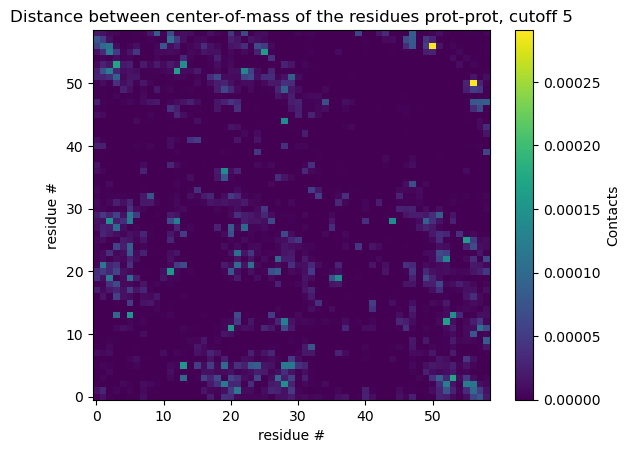

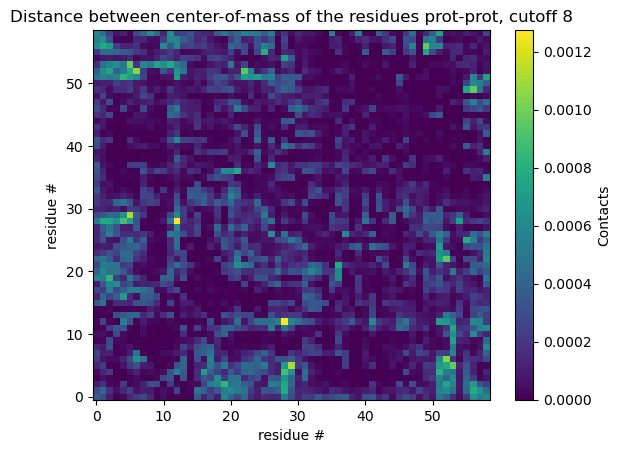

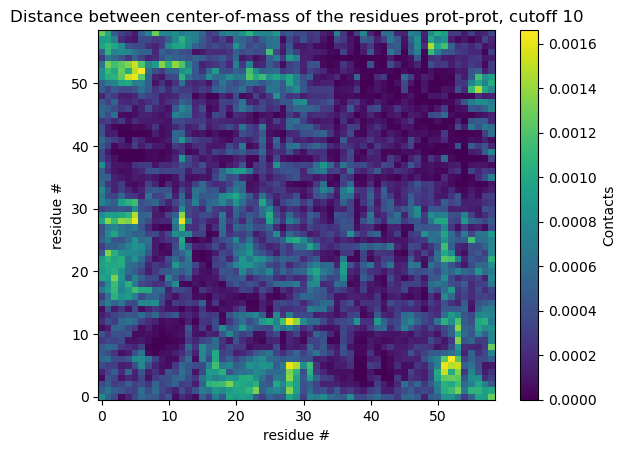

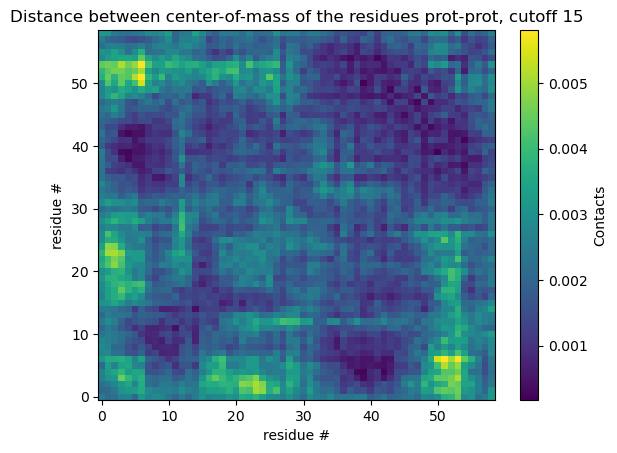

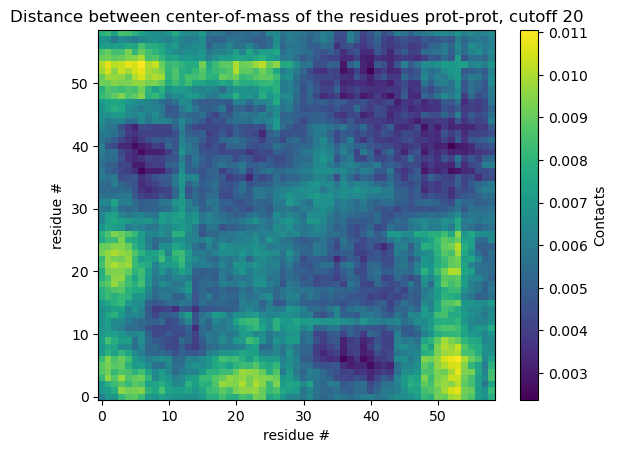

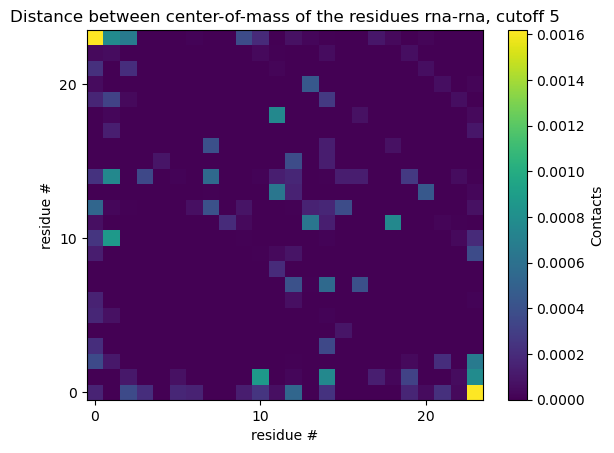

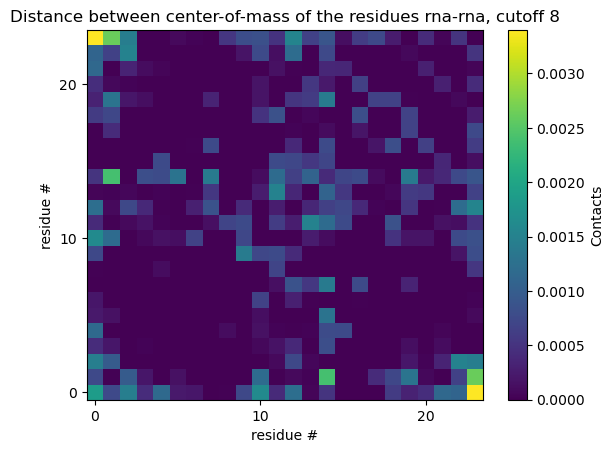

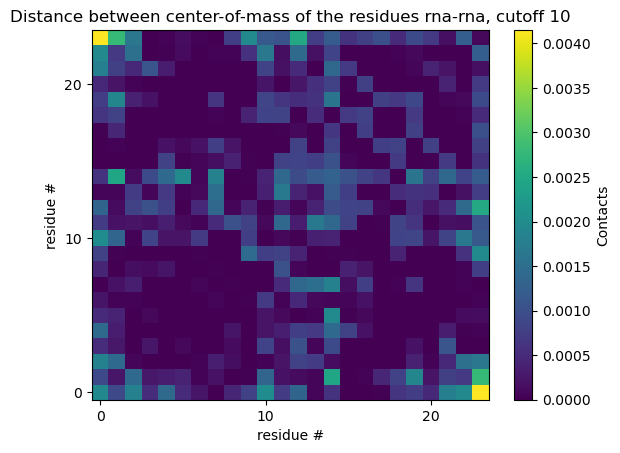

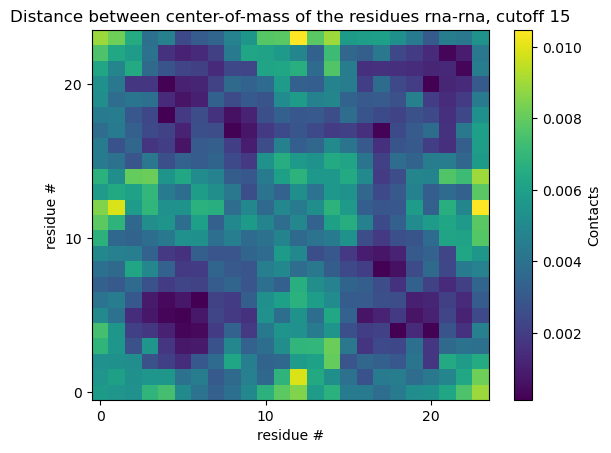

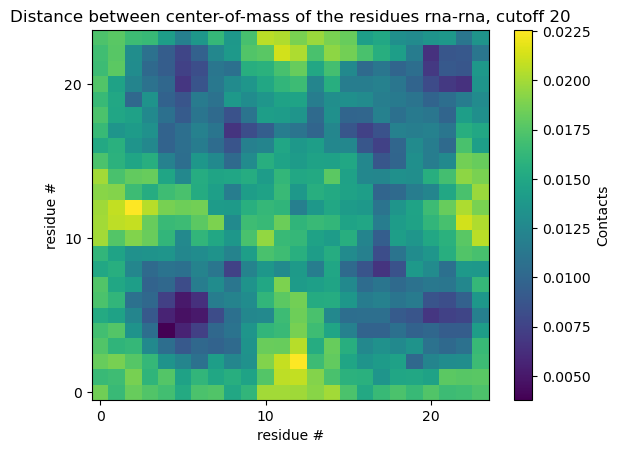

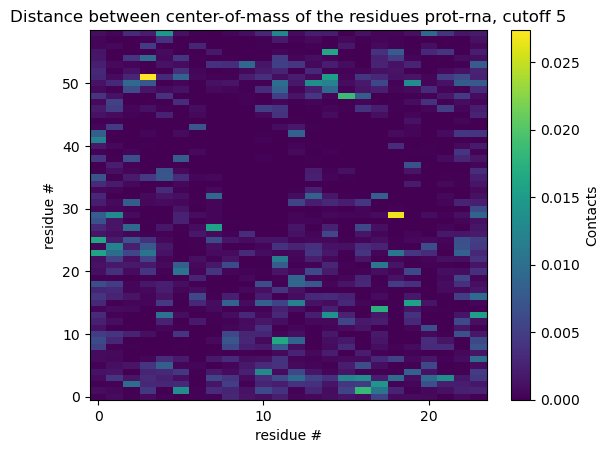

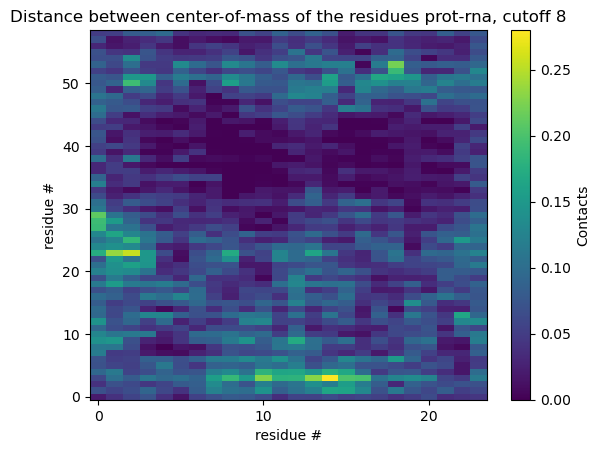

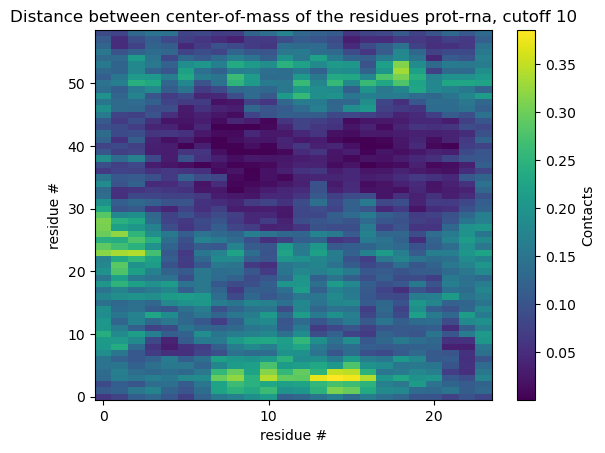

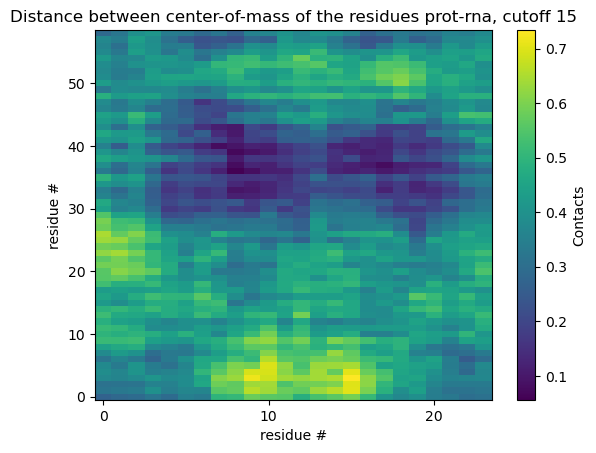

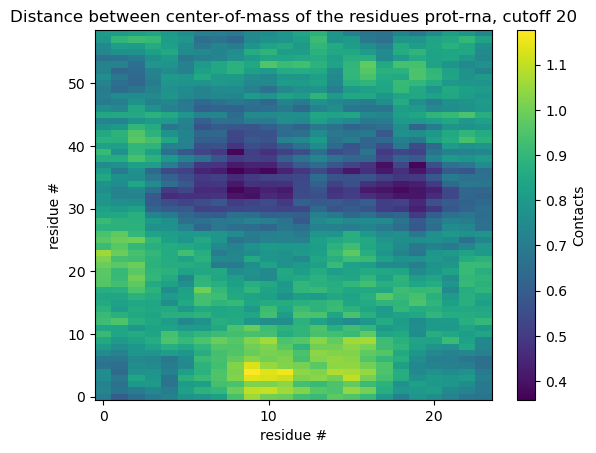

In [4]:
import os
results = []
radii = [5, 8, 10, 15, 20]

u = mda.Universe(gro_file, xtc_file)
num_frames = len(u.trajectory)

# Function to save contact maps
def save_contact_map(contact_map, filename):
    np.savetxt(filename, contact_map, delimiter=",", fmt="%.4g")

# quickly create a result folder
contact_map_dir = "results/contact_map/"
if not os.path.isdir(contact_map_dir):
    os.makedirs(contact_map_dir, exist_ok=True)

mode = "prot-prot"
for radius in radii:
    avg_inter_contacts = np.zeros((NUM_RES, NUM_RES))
    ctcs = generate_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius, mode)
    for matrix in ctcs:
        res_inter_reduced = np.zeros((matrix.shape[0], NUM_RES))
        for ind in range(NUM_RES):
            columns_to_average = matrix[:, ind::NUM_RES]
            res_inter_reduced[:, ind] = columns_to_average.mean(axis=1)
        avg_inter_contacts += res_inter_reduced
    avg_inter_contacts = avg_inter_contacts / NUM_PROTEINS
    # the contact map needs to be normalized by the number of frames
    avg_inter_contacts = avg_inter_contacts / num_frames
    save_contact_map(avg_inter_contacts, f"{contact_map_dir}contact_map_{mode}_cutoff_{radius}.csv")    
    results.append(avg_inter_contacts)

mode = "rna-rna"
results_rna_rna = []
for radius in radii:
    avg_inter_contacts = np.zeros((NUM_RES_RNA, NUM_RES_RNA))  # Ensure correct shape
    ctcs = generate_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius, mode)
    for matrix in ctcs:
        res_inter_reduced = np.zeros((matrix.shape[0], NUM_RES_RNA))
        for ind in range(NUM_RES_RNA):
            columns_to_average = matrix[:, ind::NUM_RES_RNA]
            res_inter_reduced[:, ind] = columns_to_average.mean(axis=1)
        avg_inter_contacts += res_inter_reduced
    avg_inter_contacts = avg_inter_contacts / NUM_RNA
    avg_inter_contacts = avg_inter_contacts / num_frames    
    save_contact_map(avg_inter_contacts, f"{contact_map_dir}contact_map_{mode}_cutoff_{radius}.csv")    
    results_rna_rna.append(avg_inter_contacts)

mode = "prot-rna"  # Ensure mode is reassigned here
results_prot_rna = []
for radius in radii:
    avg_inter_contacts = np.zeros((NUM_RES, NUM_RES_RNA))  # Ensure correct shape
    ctcs = generate_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius, mode)
    for matrix in ctcs:
        res_inter_reduced = np.zeros((matrix.shape[0], NUM_RES_RNA))
        for ind in range(NUM_RES_RNA):
            columns_to_average = matrix[:, ind::NUM_RES_RNA]
            res_inter_reduced[:, ind] = columns_to_average.mean(axis=1)
        avg_inter_contacts += res_inter_reduced
    avg_inter_contacts = avg_inter_contacts / NUM_PROTEINS  
    avg_inter_contacts = avg_inter_contacts / num_frames    
    save_contact_map(avg_inter_contacts, f"{contact_map_dir}contact_map_{mode}_cutoff_{radius}.csv")
    results_prot_rna.append(avg_inter_contacts)

# Now we can plot all the results
for i,radius in enumerate(radii):
   plot_dist(results[i], cutoff=radius, mode="prot-prot")
for i,radius in enumerate(radii):
    plot_dist(results_rna_rna[i], cutoff=radius, mode="rna-rna")
for i,radius in enumerate(radii):
    plot_dist(results_prot_rna[i], cutoff=radius, mode="prot-rna")

In [5]:
# this self contacts job can be used for rna as well, just take care of the offset
def sef_contacts_job(gro_file, xtc_file, start_index, end_index, radius=20):
    u = mda.Universe(gro_file, xtc_file)  # Initialize a new Universe for each job
    prot_i = u.select_atoms(f"bynum {start_index}:{end_index}")
    
    size1 = len(prot_i.center_of_mass(compound='residues'))
    tot_contacts = np.zeros((size1, size1))

    for ts in u.trajectory:
        res_com1 = prot_i.center_of_mass(compound='residues')
        com_dist = distances.distance_array(res_com1, res_com1, box=u.dimensions)
        contact_mat = contacts.contact_matrix(com_dist, radius)
        tot_contacts += contact_mat  # In-place addition to avoid memory overhead

    return tot_contacts

def generate_self_contact_map(gro_file, xtc_file, num_proteins, protein_len, num_res, radius, mode):
    """this function works in two modes RNA and prot. pretty similar but RNA 
    goes after protein, so there is an offset."""
    futures = []
    ress = []
    with ProcessPoolExecutor(max_workers=32) as executor:  # Use ProcessPoolExecutor for better performance
        if mode == "prot":
            for i in range(num_proteins):
                start_index = i * protein_len + 1
                end_index = (i + 1) * protein_len
                #print(f"Submitting job for protein {i}")
                futures.append(executor.submit(sef_contacts_job, gro_file, xtc_file, start_index, end_index, radius))
        else:
            for i in range(NUM_RNA):
                start_index = RNA_START_INDEX + i * RNA_LEN + 1
                end_index = RNA_START_INDEX + (i+1) * RNA_LEN
                futures.append(executor.submit(sef_contacts_job, gro_file, xtc_file, start_index, end_index, radius))
        
        for future in concurrent.futures.as_completed(futures):
            # print("job done")
            ress.append(future.result())  # Incrementally add each result directly to avg_self_contacts
            
    return ress

# self_contacts = generate_self_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius=15)
# self_ct = np.zeros((NUM_RES, NUM_RES))
# for ct in self_contacts:
#     self_ct += ct

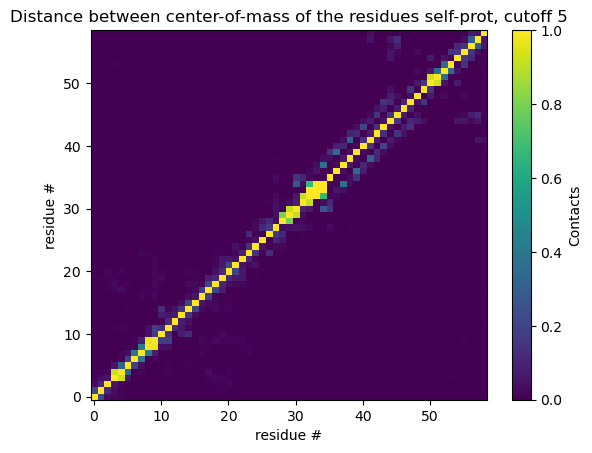

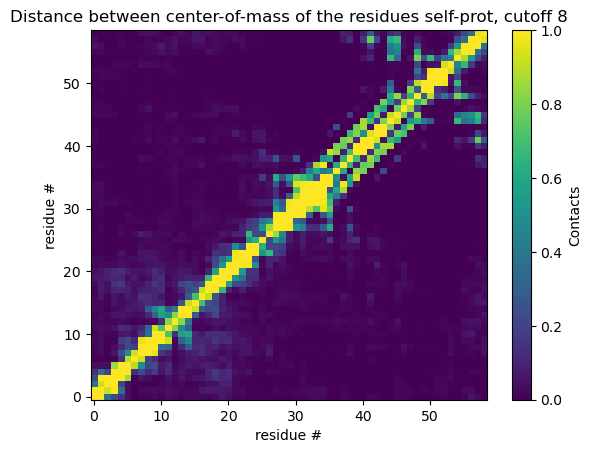

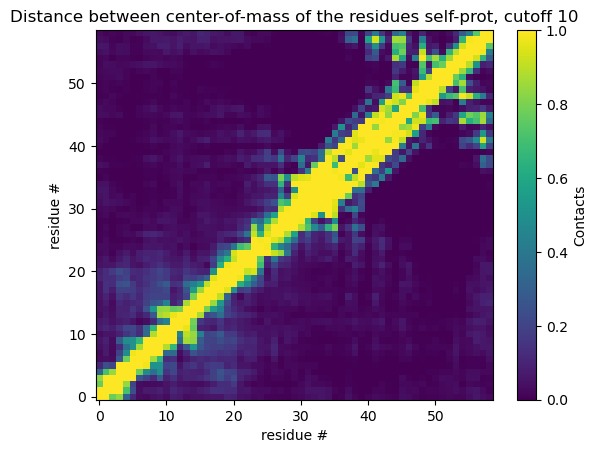

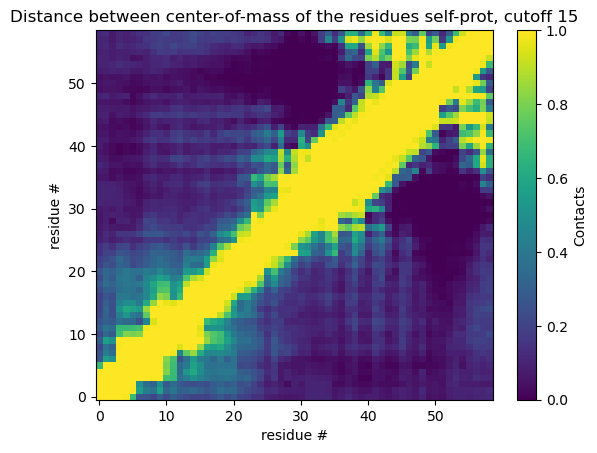

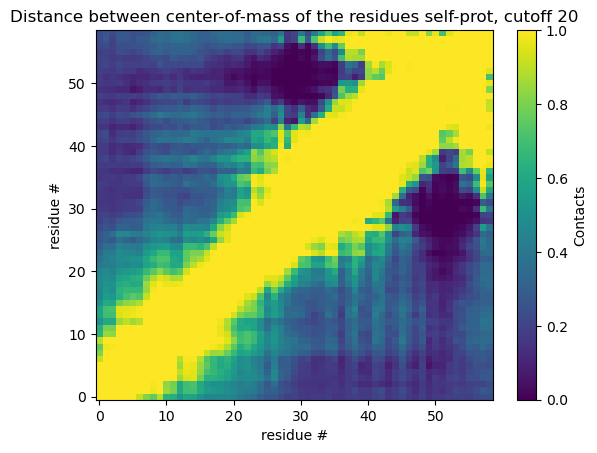

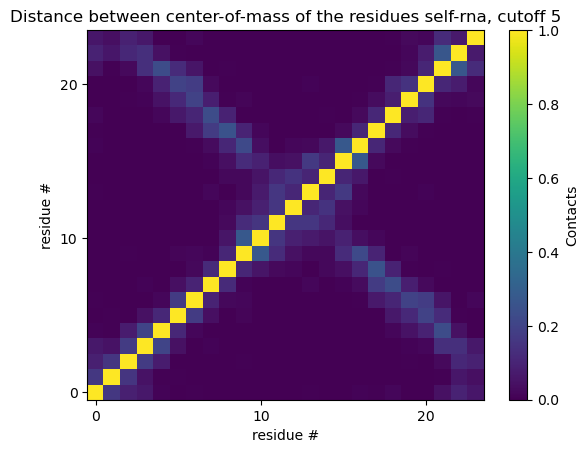

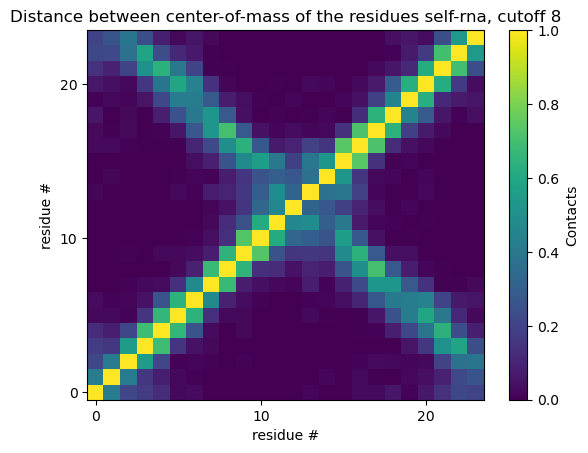

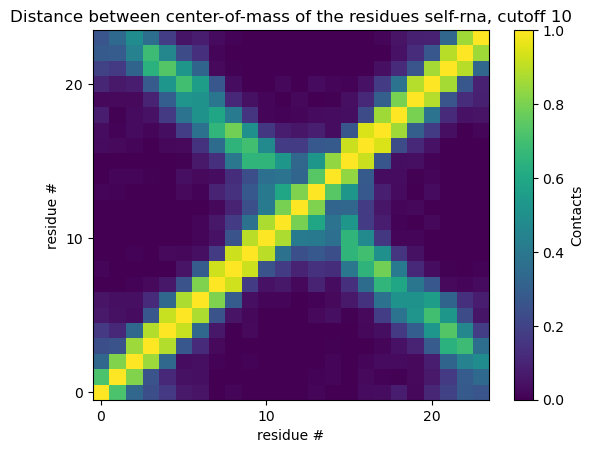

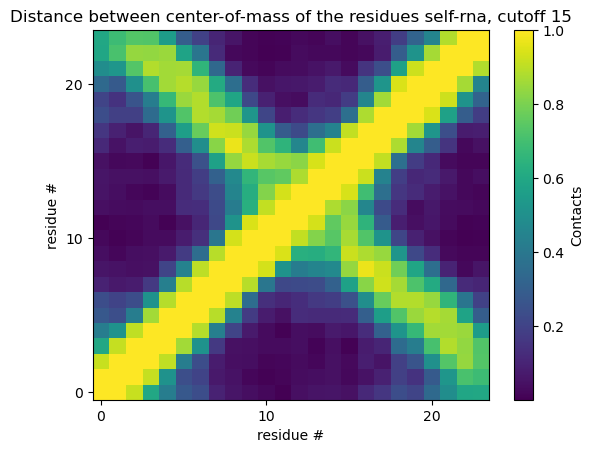

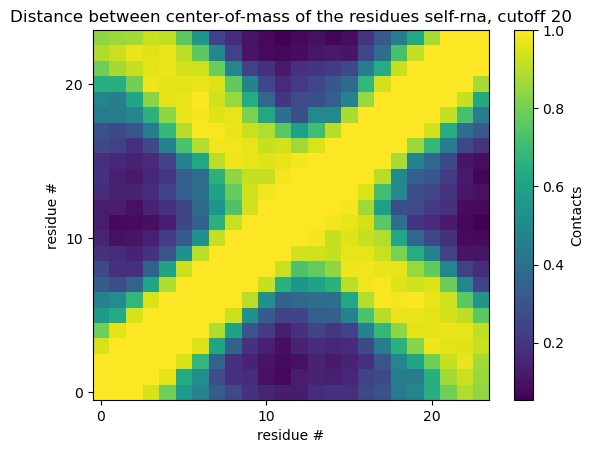

In [6]:
results = []
radii = [5, 8, 10, 15, 20]

"""One thing to note here is that I normalized it by frames and number of proteins/RNA molecules"""
mode = "prot"
for radius in radii:
    self_contacts = generate_self_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius, mode)
    self_ct = np.zeros((NUM_RES, NUM_RES))
    for ct in self_contacts:
        self_ct += ct
    self_ct = self_ct / num_frames
    self_ct = self_ct / NUM_PROTEINS
    save_contact_map(avg_inter_contacts, f"{contact_map_dir}self_contact_{mode}_cutoff_{radius}.csv")
    results.append(self_ct)
    
for i, self_ctc in enumerate(results):
    plot_dist(self_ctc, radii[i], mode="self-prot")

mode = "rna"
rna_results = []
for radius in radii:
    self_contacts = generate_self_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, NUM_RES, radius, mode)
    self_ct = np.zeros((NUM_RES_RNA, NUM_RES_RNA))
    for ct in self_contacts:
        self_ct += ct
    self_ct = self_ct / num_frames  
    self_ct = self_ct / NUM_RNA  
    save_contact_map(avg_inter_contacts, f"{contact_map_dir}self_contact_{mode}_cutoff_{radius}.csv")
    rna_results.append(self_ct)
    
for i, sel_ctc in enumerate(rna_results):
    plot_dist(sel_ctc, radii[i], mode="self-rna")